In [1]:
import pandas as pd

Instructions <br>
https://canvas.northwestern.edu/courses/246195/assignments/1692252?module_item_id=3672126

# Parsing the Dataset

Some of the code that parses all of emails takes a fair amount of time! So we'll set this constant to False if we actually want to run it. Otherwise, we'll just skip the computationally heavy stuff.

In [2]:
SKIP = True

Here's the dataset that we got from Kaggle:

In [3]:
df = pd.read_csv('emails.csv')
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


## Parsing the emails using the email library

In [4]:
import email
from email.utils import getaddresses, parsedate_to_datetime

def parse_email(raw_message):
    
    msg = email.message_from_string(raw_message)
    
    # Helper to extract names and emails separately
    def get_names_and_emails(header_name):
        addresses = getaddresses(msg.get_all(header_name, []))
        names = [addr[0] for addr in addresses if addr[0]]
        emails = [addr[1] for addr in addresses if addr[1]]
        return names, emails

    # Extract Recipient (To) and CC info
    to_names, to_emails = get_names_and_emails('To')
    cc_names, cc_emails = get_names_and_emails('Cc')
    
    # Extract Sender info
    from_header = getaddresses(msg.get_all('From', []))
    sender_name = from_header[0][0] if from_header else None
    sender_email = from_header[0][1] if from_header else None

    return pd.Series({
        'message_id': msg.get('Message-ID'),
        'sender': sender_name or msg.get('X-From'), # Fallback to X-From for display names
        'sender_email': sender_email,
        'recipient': to_names or [msg.get('X-To')],
        'recipient_email': to_emails,
        'cc': cc_names or [msg.get('X-cc')],
        'cc_email': cc_emails,
        'date_sent': parsedate_to_datetime(msg.get('Date')),
        'message_contents': msg.get_payload().strip()
    })

if not SKIP:
    df = df['message'].apply(parse_email)

In [5]:
import re

# There's a LOT of junk in the names/email column. My assumption is that it's some sort of metadata. 
# Here, we're basically removing anything in between the carrots, and leading and trailing whitespaces in the sender and recipient emails/names.
def remove_junk(s):
    """Removes junk for a single string"""
    return re.sub(re.escape('<') + r".*?" + re.escape('>'), '', s).strip()

def remove_junk_list(recipient_list):
    """Removes junk for everything in a list"""
    return [remove_junk(recipient) for recipient in recipient_list]


if not SKIP:
    for col in ['sender', 'sender_email']:
        df[col] = df[col].map(remove_junk)

    for col in ['recipient', 'recipient_email','cc', 'cc_email']:
        df[col] = df[col].map(remove_junk_list)

    df.dropna(inplace=True)
    df.to_csv('EnronEmails.csv')

else:
    df = pd.read_csv('EnronEmails.csv')

df.head()

,Unnamed: 0,message_id,sender,sender_email,recipient,recipient_email,cc,cc_email,date_sent,message_contents
0,0,<18782981.1075855378110.JavaMail.evans@thyme>,Phillip K Allen,phillip.allen@enron.com,['Tim Belden <Tim Belden/Enron@EnronXGate>'],['tim.belden@enron.com'],[''],[],2001-05-14 16:39:00-07:00,Here is our forecast
1,1,<15464986.1075855378456.JavaMail.evans@thyme>,Phillip K Allen,phillip.allen@enron.com,['John J Lavorato <John J Lavorato/ENRON@enron...,['john.lavorato@enron.com'],[''],[],2001-05-04 13:51:00-07:00,Traveling to have a business meeting takes the...
2,2,<24216240.1075855687451.JavaMail.evans@thyme>,Phillip K Allen,phillip.allen@enron.com,['Leah Van Arsdall'],['leah.arsdall@enron.com'],[''],[],2000-10-18 03:00:00-07:00,test successful. way to go!!!
3,3,<13505866.1075863688222.JavaMail.evans@thyme>,Phillip K Allen,phillip.allen@enron.com,['Randall L Gay'],['randall.gay@enron.com'],[''],[],2000-10-23 06:13:00-07:00,"Randy,\n\n Can you send me a schedule of the s..."
4,4,<30922949.1075863688243.JavaMail.evans@thyme>,Phillip K Allen,phillip.allen@enron.com,['Greg Piper'],['greg.piper@enron.com'],[''],[],2000-08-31 05:07:00-07:00,Let's shoot for Tuesday at 11:45.


# Creating Memgraph Database

In [6]:
from neo4j import GraphDatabase
# I did really try to automate this on my own, but there were some neat tricks with the "UNWIND" cypher keyword that made this process much easier. 
# Link to AI session: https://gemini.google.com/share/8301ff5886e9

PORT = "bolt://localhost:7687"
AUTH = ("", "")
CYPHER_QUERY = """
    MERGE (s:Person {`email address`: $sender})
    
    WITH s
    UNWIND $recipients AS recipient_email
    
    MERGE (t:Person {`email address`: recipient_email})
    MERGE (s)-[r:EMAILED]->(t)
        ON CREATE SET r.weight = 1
        ON MATCH SET r.weight = r.weight + 1
"""

def add_emails(tx, sender, recipients):
    tx.run(CYPHER_QUERY, sender=sender, recipients=recipients)

if not SKIP:
    with GraphDatabase.driver(PORT, auth=AUTH) as driver:
        with driver.session() as session:
            for index, row in df.iterrows():
                recipients = row['recipient_email']
                
                # Sanity check: If recipients is just a string, wrap it in a list
                if isinstance(recipients, str):
                    recipients = [recipients]

                session.execute_write(add_emails, row['sender'], recipients)

<div class="alert alert-block alert-warning">
Note: My code above has some interesting errors that I did not encounter while testing the first couple rows. It also took 25 hours to execute, so I will be moving forward despite these errors.
I misunderstood the UNWIND keyword, and many of my nodes are not parsed correctly. Some mistakes are harmless, but also sometimes emails are sent to an apparently popular person named "[]"
</div>

# The Assignment

Choose 10 of the 18 Exercises below. Generate and Execute Python code for those exercises.

### 2.41

1.   How many nodes and links are in this network?

2.   Which of the following best describes the connectedness of this network?<br>
    a.   Strongly connected<br>
    b.   Weakly connected<br>
    c.   Connected<br>
    d.   Disconnected

3.   We want to obtain some idea about the average length of paths in this network, but with large networks like this it is often too computationally expensive to calculate the shortest path between every pair of nodes. If we wanted to compute the shortest path between every pair of nodes in this network, how many shortest-path calculations would be required? In other words, how many pairs of nodes are there in this network? (Hint: Remember this network is undirected and we usually ignore self-loops, especially when computing paths.)

4.   To save time, let’s try a sampling approach. You can obtain a random pair of nodes with `random.sample(G.nodes, 2)`<br>
    Since this sampling is done without replacement, it prevents you from picking the same node twice. Do this 1000 times and for each such pair of nodes, record the length of the shortest path between them. Take the mean of this sample to obtain an estimate for the average path length in this network. Report your estimate to one decimal place.

5.   Apply a slight modification to the above procedure to estimate the diameter of the network. Report the approximate diameter.

6.   What is the average clustering coefficient for this network? Answer to at least two decimal places.

7.   Is this network assortative or disassortative? Answer this question using the two methods shown in the text. Do the answers differ?

### 3.24

1.   What proportion of nodes have degree 100 or greater?

2.   What is the maximum degree for nodes in this network?

3.   Users in this network are anonymized by giving the nodes numerical names. Which node has the highest degree?

4.   What is the 95th percentile for degree (i.e. the value such that 95% of nodes have this degree or less)?

5.   What is the mean degree for nodes in this network? Round to the nearest integer.

6.   Which of the following shapes best describes the degree distribution in this network? You can obtain the answer visually using histograms, or just with statistics.<br>
    a.   Uniform: node degrees are evenly distributed between the minimum and maximum<br>
    b.   Normal: most node degrees are near the mean, dropping off rapidly in both directions<br>
    c.   Right-tailed: most node degrees are relatively small compared to the range of degrees<br>
    d.   Left-tailed: most node degrees are relatively large compared to the range of degrees<br>

### 5.27

1.   What is the 95th percentile for degree in the random network (i.e. the value such that 95% of nodes have this degree or less)?

2.   We are dealing with a random network, so some properties are going to differ somewhat each time one is generated. True or false: Given fixed parameters N and L, all random networks created with gnm_random_graph() will have the same mean degree.

3.   Which of the following shapes best describes the degree distribution in this random network?<br>
    a. Uniform: node degrees are evenly distributed between the minimum and maximum<br>
    b.   Normal: most node degrees are near the mean, dropping off rapidly in both directions<br>
    c.   Right-tailed: most node degrees are relatively small compared to the range of degrees<br>
    d.   Left-tailed: most node degrees are relatively large compared to the range of degrees

4.   Estimate the average shortest-path length in this random network using a random sample of 1000 pairs of nodes.

5.   What is the average clustering coefficient of this random network? Answer to at least two decimal places.

In [41]:
# This is the method that I will use to query the database
def query_db(tx, q):
    result = tx.run(q)
    for record in result:
        print(record)
    return record

def query_db_list(tx, q):
    result = tx.run(q)
    return list(result)

### Question 1

2.41.1 <br>
How many nodes and links are in this network?

In [43]:
q = """
    MATCH (n)
    WITH count(n) AS total_nodes
    MATCH ()-[r]->()
    RETURN total_nodes, count(r) AS total_edges
    """

with GraphDatabase.driver(PORT, auth=AUTH) as driver:
        with driver.session() as session:
            q1 = session.execute_read(query_db, q)

<Record total_nodes=86564 total_edges=111567>


In [44]:
print(q1['total_nodes'])
print(q1['total_edges'])

86564
111567


### Question 2

2.41.2<br>
Which of the following best describes the connectedness of this network?<br>
    a.   Strongly connected<br>
    b.   Weakly connected<br>
    c.   Connected<br>
    d.   Disconnected

In [ ]:
# WOW! The memgraph analyzer is really cool.
# It took me a long time to find this, but it saved a lot of time.
# https://memgraph.com/docs/advanced-algorithms/available-algorithms/graph_analyzer

q = """
CALL graph_analyzer.analyze([
    "is_weakly_connected", "is_strongly_connected"
    ])
YIELD name, value
RETURN name, value;
    """

with GraphDatabase.driver(PORT, auth=AUTH) as driver:
    with driver.session() as session:
        result = session.execute_read(query_db, q)

<Record name='Is weakly connected' value='False'>
<Record name='Is strongly connected' value='False'>


My graph is neither strongly connected, nor is it weakly connected. So I would say it is DISCONNECTED. It appears that some emails form communities that are separate from the rest of the graph. It's possible that this is due to some of the bugs I introduced with improperly parsed email names, however.

### Question 3

3.24.1<br>
What proportion of nodes have degree 100 or greater?

In [46]:
q = """
    MATCH (n)-[r]-()
    WITH n, count(r) AS degree
    WHERE degree >= 100
    RETURN count(n)
    """

with GraphDatabase.driver(PORT, auth=AUTH) as driver:
    with driver.session() as session:
        result = session.execute_read(query_db, q)

<Record count(n)=209>


In [47]:
# Proportion of nodes with deg >= 100
result['count(n)'] / q1['total_nodes']

0.002414398595258999

### Question 4

3.24.2<br>
What is the maximum degree for nodes in this network?

In [55]:
q = """
    MATCH (n)-[r]-()
    WITH n, count(r) AS degree
    RETURN n, degree
    ORDER BY degree DESC
    LIMIT 2
    """

with GraphDatabase.driver(PORT, auth=AUTH) as driver:
    with driver.session() as session:
        result = session.execute_read(query_db_list, q)

# Here, we see the bug from before. element_id is a person with an EMPTY email address. While this is technically the highest degree node, I'll use klay@enron.com instead.
print(result)
print(result[-1]['degree'])

[<Record n=<Node element_id='99' labels=frozenset({'Person'}) properties={'email address': '[]'}> degree=2040>, <Record n=<Node element_id='45069' labels=frozenset({'Person'}) properties={'email address': "['klay@enron.com']"}> degree=1288>]
1288


### Question 5

3.24.3<br>
Users in this network are anonymized by giving the nodes numerical names. Which node has the highest degree?

In [64]:
# See the query above
result[-1]['n']['email address']

"['klay@enron.com']"

### Question 6

3.24.4<br>
What is the 95th percentile for degree (i.e. the value such that 95% of nodes have this degree or less)?

In [65]:
q = """
    MATCH (n)-[r]-()
    WITH n, count(r) AS degree
    RETURN degree
    ORDER BY degree DESC
    """

with GraphDatabase.driver(PORT, auth=AUTH) as driver:
    with driver.session() as session:
        result = list(session.execute_read(query_db_list, q))

In [72]:
import numpy as np

degs = [n['degree'] for n in result]

print('95th percentile:')
print(np.percentile(degs, 95))

95th percentile:
5.0


### Question 7

3.24.5<br>
What is the mean degree for nodes in this network? Round to the nearest integer.

In [75]:
print('Mean degree')
print(np.round(np.mean(degs)).astype(int))

Mean degree
3


### Question 8

5.27.3<br>
Which of the following shapes best describes the degree distribution in this random network?<br>
    a. Uniform: node degrees are evenly distributed between the minimum and maximum<br>
    b.   Normal: most node degrees are near the mean, dropping off rapidly in both directions<br>
    c.   Right-tailed: most node degrees are relatively small compared to the range of degrees<br>
    d.   Left-tailed: most node degrees are relatively large compared to the range of degrees

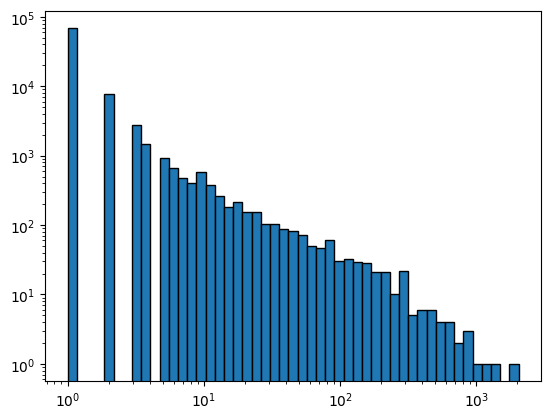

In [82]:
import matplotlib.pyplot as plt

bins = np.geomspace(min(degs), max(degs), num=50) 
plt.hist(degs, bins=bins, edgecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.show()

It looks like we might have a scale free network here! Most of our nodes have very few connections (we saw that 95th percentile was 5 above), but we have a few nodes with over 1000 connections.
We have a <b>Right Tailed</b> shape.

### Question 9

5.27.4<br>
Estimate the average shortest-path length in this random network using a random sample of 1000 pairs of nodes.

In [100]:
q = """
    MATCH (n)
    RETURN n
    ORDER BY rand()
    LIMIT 2000
"""

with GraphDatabase.driver(PORT, auth=AUTH) as driver:
    with driver.session() as session:
        nodes = list(session.execute_read(query_db_list, q))

In [121]:
node_pairs = []

for i in range(1, len(nodes), 2):
    node_pairs.append([nodes[i-1]['n']._properties['email address'], nodes[i]['n']._properties['email address']])

In [ ]:
q_sp = """
MATCH (a:Person), (b:Person)
WHERE a.`email address` = $email1
  AND b.`email address` = $email2
WITH a, b
MATCH p = (a)-[*KSHORTEST|1]-(b)
RETURN length(p) AS len
"""

lengths = []

with GraphDatabase.driver(PORT, auth=AUTH) as driver:
    with driver.session() as session:
        for email1, email2 in node_pairs:
            record = session.run(q_sp, email1=email1, email2=email2).single()
            if record is not None and record["len"] is not None:
                lengths.append(record["len"])

In [129]:
np.mean(lengths)

np.float64(5.197530864197531)

### Question 10

5.27.5<br>
What is the average clustering coefficient of this random network? Answer to at least two decimal places.

In [137]:
q = """
    MATCH (n)
    WITH n ORDER BY rand() LIMIT 20
    MATCH (n)-[]-(m)
    WITH collect(DISTINCT n) + collect(DISTINCT m) AS sample
    CALL nxalg.clustering(sample)
    YIELD node, clustering
    RETURN node, clustering
    ORDER BY clustering DESC
"""

with GraphDatabase.driver(PORT, auth=AUTH) as driver:
    with driver.session() as session:
        clust_coef = [n['clustering'] for n in session.execute_read(query_db_list, q)]

In [141]:
clust_coef[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

I think this query is correct. I tried several times. The memgraph documentation is quite good. Here, I attempt to use networkx directly in memgraph, but my network is flawed. Sometimes emails surrounded by brackets, and sometimes they are not parsed at all (see below). I could try to run this globally, but it takes a long time to check all 86,000+ nodes. In future uses, I'll probably just normalize my dataframe (or csv, etc) completely before ever attempting to migrate it to memgraph. 

The immediate result of my problem is that most of my edges are between a person and some subset of unique audiences that they sent their emails to. Unfortunately, there's not enough time to fix it!

In [147]:
# Things like this are the problem.
nodes[0]['n']['email address']

"['david.delainey@enron.com', 'philippe.bibi@enron.com', 'tim.belden@enron.com', 'raymond.bowen@enron.com', 'michael.brown@enron.com', 'rick.buy@enron.com', 'wes.colwell@enron.com', 'david.cox@enron.com', 'janet.dietrich@enron.com', 'w.duran@enron.com', 'jim.fallon@enron.com', 'ben.glisan@enron.com', 'joe.gold@enron.com', 'mark.haedicke@enron.com', 'james.hughes@enron.com', 'louise.kitchen@enron.com', 'michael.kopper@enron.com', 'john.lavorato@enron.com', 'dan.leff@enron.com', 'jeffrey.mcmahon@enron.com', 'rob.milnthorp@enron.com', 'matthew.scrimshaw@enron.com', 'jeffrey.shankman@enron.com', 'richard.shapiro@enron.com', 'marty.sunde@enron.com']"